In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from nose.tools import *

from collections import Counter 

from scipy.stats import ttest_ind
from scipy.stats import f_oneway

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# World Food Facts and Health Effects

## Svetlana Topalova

### Abstract

What the world eats? What the food we eat actually contains? And what is the impact on our bodies from the food choices we make? 
We will try to answer these questions or at least analyze the relations between eating certain foods and health consequences.

### Analyzing foods data

First we are going to read the dataset and find the most important features of the food categories.
* "data/food-facts.tsv" is taken from https://softuni.bg/downloads/svn/Data-Science/Jun-2018/09.%20Exam/world-food-facts.zip

In [3]:
food_data = pd.read_table("data/food-facts.tsv", low_memory = False)
food_data.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,0000000016087,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,0000000016094,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Food data properties

We will see the main properties of the food data like shape and column names

In [4]:
print("Food data shape: {}".format(food_data.shape))
columns = ", ".join(food_data.columns)
print("Food data columns: {}".format(columns))

Food data shape: (356027, 163)
Food data columns: code, url, creator, created_t, created_datetime, last_modified_t, last_modified_datetime, product_name, generic_name, quantity, packaging, packaging_tags, brands, brands_tags, categories, categories_tags, categories_en, origins, origins_tags, manufacturing_places, manufacturing_places_tags, labels, labels_tags, labels_en, emb_codes, emb_codes_tags, first_packaging_code_geo, cities, cities_tags, purchase_places, stores, countries, countries_tags, countries_en, ingredients_text, allergens, allergens_en, traces, traces_tags, traces_en, serving_size, no_nutriments, additives_n, additives, additives_tags, additives_en, ingredients_from_palm_oil_n, ingredients_from_palm_oil, ingredients_from_palm_oil_tags, ingredients_that_may_be_from_palm_oil_n, ingredients_that_may_be_from_palm_oil, ingredients_that_may_be_from_palm_oil_tags, nutrition_grade_uk, nutrition_grade_fr, pnns_groups_1, pnns_groups_2, states, states_tags, states_en, main_category,

#### Food data cleaning

Now we will remove the columns that are not relevant for our research. We will leave only columns containing information about food name, category, additives, substance per 100g.

In [5]:
food_data_filtered = food_data.filter(regex='name|categor|additives|_100g', axis=1)

Most important and readable information for us is in columns categories_en and energy_100g. So we filter the dataframe by valid information in that columns. We define that zero or more than 2000 kcal per 100g is not normal and remove these rows.

In [6]:
print("Mean Energy per 100g: {0}".format(food_data_filtered["energy_100g"].mean())) 
print("Lowest Energy per 100g: {0}".format(food_data_filtered["energy_100g"].nsmallest(1)))
print("Highest Energy per 100g: {0}".format(food_data_filtered["energy_100g"].nlargest(1)))

Mean Energy per 100g: 1125.4533198698575
Lowest Energy per 100g: 233    0.0
Name: energy_100g, dtype: float64
Highest Energy per 100g: 347260    231199.0
Name: energy_100g, dtype: float64


In [7]:
food_data_filtered = food_data_filtered[(food_data["categories_en"].notnull()) & (food_data["energy_100g"].notnull())]
food_data_filtered.drop(food_data_filtered[(food_data_filtered["energy_100g"]<=0) | (food_data_filtered["energy_100g"]>=2000)].index, inplace=True)
print("Fitered data shape: {0}".format(food_data_filtered.shape))
print("Fitered data Mean Energy per 100g: {0}".format(food_data_filtered["energy_100g"].mean())) 
print("Fitered data Lowest Energy per 100g: {0}".format(food_data_filtered["energy_100g"].nsmallest(1)))
print("Fitered data Highest Energy per 100g: {0}".format(food_data_filtered["energy_100g"].nlargest(1)))

Fitered data shape: (68548, 111)
Fitered data Mean Energy per 100g: 844.9640586304467
Fitered data Lowest Energy per 100g: 343150    0.02
Name: energy_100g, dtype: float64
Fitered data Highest Energy per 100g: 218005    1999.0
Name: energy_100g, dtype: float64


#### Finding category foods with highest levels of certain substance

First we gruop the dataframe by 'categories_en' and get the other columns mean values.

In [8]:
food_data_filtered_by_category = food_data_filtered.groupby(["categories_en"], as_index=False).mean()

In [9]:
def find_categories_most_common_phrases_and_words(categories_names):
    categories_text = ";".join(categories_names)
    categories_phases = map(str.lower,re.split("[,;]+", categories_text))
    most_common_phases = Counter(categories_phases).most_common(10)
    categories_words = map(str.lower,re.split("[\s,;]+", categories_text))
    # clear not meaningful words
    stopwords = ['product', 'products', 'food', 'foods', 'meal', 'meals', 'and', 'with', 
                'fresh', 'prepared', 'pasteurized', 'french', 'pressed', 'de', 'cooked',
                'canned', 'plant-based', 'beverages', 'their', 'based']
    filtered_categories_words = [word for word in categories_words if word not in stopwords]
    most_common_categories_words = Counter(filtered_categories_words).most_common(10)
    return {"phrases": most_common_phases, "words": most_common_categories_words}

#### Finding highest fat food categories

Lets see which are the categories with highest fat per 100g and what else they contain.

In [10]:
highest_fat_categories = food_data_filtered_by_category.nlargest(1000, 'fat_100g')
highest_fat_categories_names = highest_fat_categories["categories_en"]
print("highest fat food categories {}".format(find_categories_most_common_phrases_and_words(highest_fat_categories_names)))

highest fat food categories {'phrases': [('dairies', 471), ('cheeses', 418), ('cow cheeses', 213), ('pasteurized cheeses', 174), ('meats', 172), ('prepared meats', 150), ('fresh foods', 148), ('french cheeses', 146), ('spreads', 119), ('salted spreads', 97)], 'words': [('cheeses', 1574), ('dairies', 471), ('meats', 351), ('spreads', 255), ('cow', 213), ('cheese', 153), ('salted', 97), ('sauces', 95), ('emmentaler', 90), ('groceries', 79)]}


In [11]:
highest_fat_categories.mean().nlargest(20)

energy_100g                             1543.562237
energy-from-fat_100g                    1263.588235
carbon-footprint_100g                   1168.005470
cocoa_100g                                56.770833
polyols_100g                              34.277778
fat_100g                                  33.784191
nutrition-score-uk_100g                   18.333271
nutrition-score-fr_100g                   16.148715
saturated-fat_100g                        16.007955
proteins_100g                             15.426168
monounsaturated-fat_100g                  14.808504
-linoleic-acid_100g                       14.260000
omega-6-fat_100g                          12.475000
starch_100g                               11.266667
polyunsaturated-fat_100g                  11.258683
fruits-vegetables-nuts-estimate_100g       8.700000
ph_100g                                    7.700000
-alpha-linolenic-acid_100g                 5.274479
carbohydrates_100g                         5.250120
omega-3-fat_

##### Finding highest trans fat food categories

In [12]:
highest_trans_fat_categories = food_data_filtered_by_category.nlargest(100, 'trans-fat_100g')
highest_trans_fat_categories_names = highest_trans_fat_categories["categories_en"]
print("highest trans fat food categories {}".format(find_categories_most_common_phrases_and_words(highest_trans_fat_categories_names)))

highest trans fat food categories {'phrases': [('meals', 26), ('sugary snacks', 19), ('microwave meals', 19), ('meals with meat', 17), ('biscuits and cakes', 13), ('dairies', 12), ('fresh foods', 12), ('desserts', 11), ('fresh meals', 10), ('plant-based foods and beverages', 9)], 'words': [('cakes', 21), ('biscuits', 20), ('sugary', 19), ('snacks', 19), ('microwave', 19), ('spreads', 18), ('meat', 18), ('fats', 17), ('dairies', 12), ('desserts', 12)]}


In [13]:
highest_trans_fat_categories.mean().nlargest(20)

energy_100g                    1079.587801
energy-from-fat_100g            514.804762
carbon-footprint_100g           348.000000
starch_100g                      36.200000
cocoa_100g                       30.000000
carbohydrates_100g               24.229653
polyols_100g                     22.296296
-linoleic-acid_100g              14.350000
fat_100g                         13.871308
fruits-vegetables-nuts_100g      13.421111
-oleic-acid_100g                 11.000000
sugars_100g                       9.693059
nutrition-score-uk_100g           9.553464
nutrition-score-fr_100g           9.084592
proteins_100g                     8.547682
monounsaturated-fat_100g          7.046724
omega-6-fat_100g                  5.911667
saturated-fat_100g                5.441740
polyunsaturated-fat_100g          4.158189
additives_n                       3.163393
dtype: float64

#### Finding highest sugars food categories

In [14]:
highest_sugar_categories = food_data_filtered_by_category.nlargest(500, 'sugars_100g')
highest_sugar_categories_names = highest_sugar_categories["categories_en"]
print("highest sugars food categories {}".format(find_categories_most_common_phrases_and_words(highest_sugar_categories_names)))

highest sugars food categories {'phrases': [('sweeteners', 144), ('beverages', 114), ('sugary snacks', 109), ('syrups', 101), ('breakfasts', 98), ('spreads', 83), ('sweet spreads', 83), ('confectioneries', 79), ('sugared beverages', 77), ('bee products', 73)], 'words': [('syrups', 258), ('spreads', 175), ('sweeteners', 144), ('fruits', 115), ('snacks', 111), ('sugary', 109), ('breakfasts', 98), ('fr:miels', 90), ('honeys', 88), ('confectioneries', 85)]}


#### Finding highest additives food categories

In [15]:
#food_data_filtered_by_additives = food_data_filtered.groupby(["additives_en"], as_index=False).mean()
highest_additives_categories = food_data_filtered.nlargest(1000, 'additives_n')
highest_additives_categories_names = highest_additives_categories["categories_en"]
print("highest additives food categories {}".format(find_categories_most_common_phrases_and_words(highest_additives_categories_names)))

highest additives food categories {'phrases': [('sugary snacks', 397), ('confectioneries', 232), ('sandwiches', 194), ('desserts', 189), ('biscuits and cakes', 146), ('chewing gum', 135), ('meals', 122), ('cakes', 107), ('candies', 92), ('frozen foods', 77)], 'words': [('sandwiches', 497), ('snacks', 412), ('sugary', 397), ('cakes', 290), ('desserts', 261), ('confectioneries', 232), ('gum', 189), ('chewing', 188), ('biscuits', 171), ('candies', 130)]}


### Food consumption worldwide

Let's investigate what food people around the world eat. The source of the datasets is https://ourworldindata.org/ and they have similar structure: column "Entity" contains the country and last year of the data is 2013. First we will get the mean value by country (Entity) since 2011. Column "Year" contains the year which is not relevant for our research and we will drop it.
We will do similar operations on the data so we use a function group_data_by_country for that.

In [16]:
def group_data_by_country(dataframe, year = 2011):
    dataframe = dataframe[dataframe["Year"] >= year]
    dataframe = dataframe.groupby(["Entity"]).mean()
    dataframe = dataframe.drop(columns=["Year"])
    return dataframe

#### Diet compositions by macronutrient
Daily caloric supply derived from carbohydrates, protein and fat all measured in kilocalories per person per day

In [17]:
caloric_supply = pd.read_csv("data/daily-caloric-supply-derived-from-carbohydrates-protein-and-fat.csv")
caloric_supply_by_country = group_data_by_country(caloric_supply)
caloric_supply_by_country.columns = ["animal protein", "plant protein", "fat", "carbohydrates"] 
caloric_supply_by_country.head()

,animal protein,plant protein,fat,carbohydrates
Entity,,,,
Afghanistan,48.880000,185.880000,299.91,1564.330000
Albania,234.053333,207.706667,945.54,1782.366667
Algeria,100.240000,262.733333,685.02,2213.673333
Angola,72.200000,152.986667,476.37,1719.776667
Antigua and Barbuda,225.613333,104.466667,801.93,1227.656667


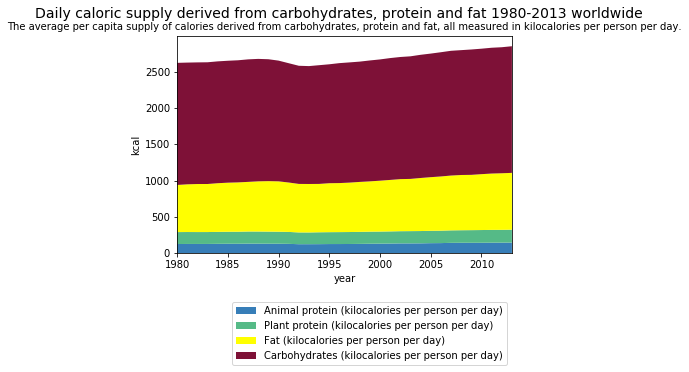

In [18]:
caloric_supply_since_1980 = caloric_supply[caloric_supply["Year"] >= 1980]
caloric_supply_since_1980 = caloric_supply_since_1980.groupby(["Year"]).mean()

plt.stackplot(caloric_supply_since_1980.index.values, caloric_supply_since_1980.T, colors=['#377EB8','#55BA87', 'yellow', '#7E1137'])
plt.xlim(1980, 2013)
plt.xlabel("year")
plt.ylabel("kcal")
plt.legend(caloric_supply_since_1980.columns, bbox_to_anchor=(1,-0.2))
plt.suptitle("Daily caloric supply derived from carbohydrates, protein and fat 1980-2013 worldwide", fontsize=14)
plt.title("The average per capita supply of calories derived from carbohydrates, protein and fat, all measured in kilocalories per person per day.", fontsize=10)
plt.show()

#### Dietary compositions by commodity group 
Dietary compositions by commodity group average per capita dietary energy supply by commodity groups, measured in kilocalories per person perday.

In [19]:
commodity_groups_compositions = pd.read_csv("data/dietary-compositions-by-commodity-group-1961-2013.csv")
commodity_groups_compositions_by_country = group_data_by_country(commodity_groups_compositions)
commodity_groups_compositions_by_country.columns = ["other", "sugar", "oils & fat", "meat","dairy & eggs", 
                                                   "fruits & vegetables","starchy", "pulses", "cereals & grains", 
                                                   "alcoholic"]
#commodity_groups_compositions_by_country["total_calories"] = commodity_groups_compositions_by_country.sum(axis=1)
commodity_groups_compositions_by_country.head()

,other,sugar,oils & fat,meat,dairy & eggs,fruits & vegetables,starchy,pulses,cereals & grains,alcoholic
Entity,,,,,,,,,,
Afghanistan,15.666667,86.333333,146.333333,70.000000,102.666667,64.333333,13.666667,23.333333,1576.666667,0.000000
Albania,32.333333,195.666667,319.666667,338.000000,569.333333,373.666667,77.666667,48.333333,1142.000000,73.000000
Algeria,34.000000,266.000000,407.666667,101.000000,259.333333,318.333333,126.000000,70.333333,1672.666667,6.333333
Angola,15.000000,139.000000,266.333333,206.333333,26.000000,156.666667,712.333333,81.000000,706.000000,112.666667
Antigua and Barbuda,63.666667,288.000000,336.333333,448.666667,234.333333,217.000000,47.000000,25.333333,627.666667,71.666667


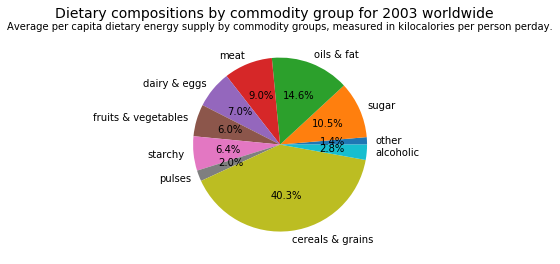

In [20]:
commodity_groups_compositions_2013 = commodity_groups_compositions[commodity_groups_compositions["Year"] == 2003]
commodity_groups_compositions_2013 = commodity_groups_compositions_2013.drop(columns=["Year"])
group_names = ["other", "sugar", "oils & fat", "meat","dairy & eggs", 
                                                   "fruits & vegetables","starchy", "pulses", "cereals & grains", 
                                                   "alcoholic"]
groups_values = commodity_groups_compositions_2013.mean()
plt.pie(groups_values, labels=group_names, autopct='%.1f%%')
plt.gca().set_aspect("equal")

plt.suptitle("Dietary compositions by commodity group for 2003 worldwide", fontsize=14)
plt.title("Average per capita dietary energy supply by commodity groups, measured in kilocalories per person perday.", fontsize=10)
plt.show()

#### Food consumption correlations
Now let's see how consumption of certain foods correlates with each others

In [21]:
food_consumption_data_by_country = pd.concat([caloric_supply_by_country, commodity_groups_compositions_by_country], axis=1, join='outer')
food_consumption_data_by_country = food_consumption_data_by_country.dropna(how="any", axis=0)

#### Commodity group consumption correlations

In [22]:
corr = caloric_supply_by_country.corr()
corr.style.background_gradient()

,animal protein,plant protein,fat,carbohydrates
animal protein,1,-0.279576,0.857484,-0.0600695
plant protein,-0.279576,1,-0.192037,0.684466
fat,0.857484,-0.192037,1,-0.0801792
carbohydrates,-0.0600695,0.684466,-0.0801792,1


We can see strong correlation between fat and animal protein consumption almost 0.87

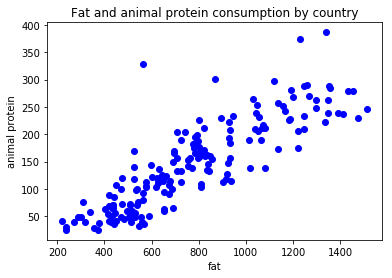

In [23]:
plt.plot(caloric_supply_by_country["fat"], caloric_supply_by_country["animal protein"], 'o', color = "blue")
plt.title("Fat and animal protein consumption by country")
plt.xlabel("fat")
plt.ylabel("animal protein")
plt.show()

In [24]:
fat_consumption_data_by_country = pd.concat([caloric_supply_by_country["fat"], commodity_groups_compositions_by_country], axis=1, join='outer')
fat_consumption_data_by_country = fat_consumption_data_by_country.dropna(how="any", axis=0)
corr = fat_consumption_data_by_country.corr()
corr.style.background_gradient()

,fat,other,sugar,oils & fat,meat,dairy & eggs,fruits & vegetables,starchy,pulses,cereals & grains,alcoholic
fat,1,0.461788,0.571377,0.852925,0.777455,0.750255,0.291183,-0.30434,-0.423902,-0.380914,0.571661
other,0.461788,1,0.29709,0.170858,0.569117,0.472882,0.255934,-0.195141,-0.329216,-0.244113,0.371728
sugar,0.571377,0.29709,1,0.433238,0.511814,0.52746,0.148495,-0.432741,-0.22607,-0.255549,0.353435
oils & fat,0.852925,0.170858,0.433238,1,0.456956,0.416148,0.201743,-0.144252,-0.291271,-0.332938,0.36931
meat,0.777455,0.569117,0.511814,0.456956,1,0.594549,0.254656,-0.276189,-0.478136,-0.416667,0.53182
dairy & eggs,0.750255,0.472882,0.52746,0.416148,0.594549,1,0.27323,-0.375485,-0.3405,-0.246662,0.548348
fruits & vegetables,0.291183,0.255934,0.148495,0.201743,0.254656,0.27323,1,0.0672368,-0.00793144,-0.222108,0.099636
starchy,-0.30434,-0.195141,-0.432741,-0.144252,-0.276189,-0.375485,0.0672368,1,0.186943,-0.325992,-0.106281
pulses,-0.423902,-0.329216,-0.22607,-0.291271,-0.478136,-0.3405,-0.00793144,0.186943,1,0.0571356,-0.330208
cereals & grains,-0.380914,-0.244113,-0.255549,-0.332938,-0.416667,-0.246662,-0.222108,-0.325992,0.0571356,1,-0.351683


We observe from the table that fat has the strongest correlations with meat and dairy & eggs and relatively strong with sugars and alcohol.

### Health condition by country
What is the impact food consumption on people's health?
Now we will investigate the connection between food consumption and people health condition by country.

#### Obesity by country

Obesity or overnourishment is defined as dietary energy intake which exceeds requirements for maintenance of a healthy bodyweight. 

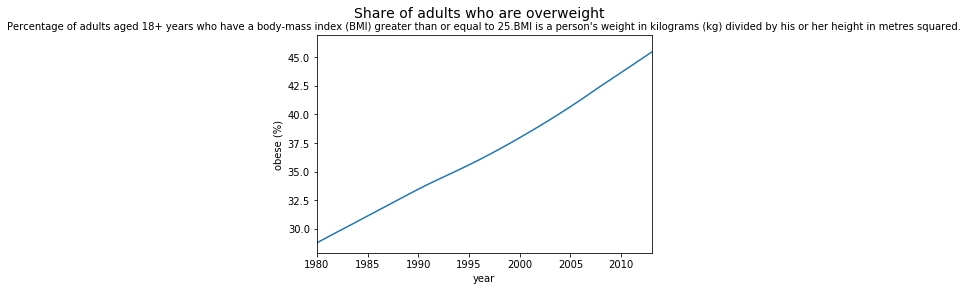

In [25]:
obesity = pd.read_csv("data/share-of-adult-men-overweight-or-obese-vs-daily-supply-of-calories.csv")
obesity_since_1980 = obesity[obesity["Year"] >= 1980]
obesity_since_1980 = obesity_since_1980.groupby(["Year"]).mean()

plt.plot(obesity_since_1980["Overweight or Obese (%)"])
plt.xlim(1980, 2013)
plt.xlabel("year")
plt.ylabel("obese (%)")
plt.suptitle("Share of adults who are overweight", fontsize=14)
plt.title("Percentage of adults aged 18+ years who have a body-mass index (BMI) greater than or equal to 25.BMI is a person's weight in kilograms (kg) divided by his or her height in metres squared.", fontsize=10)
plt.show()

Now lets investigate if obesity is related with certain type of food. First we will group by country again and concatenate with food_consumption_data_by_country

In [26]:
obesity_by_country = group_data_by_country(obesity)
obesity_by_country.columns = ["kcal per day", "obese percentage", "total population"]
obesity_by_country = obesity_by_country.drop(columns=["total population"])
food_consumption_and_obesity_data_by_country = pd.concat([food_consumption_data_by_country, obesity_by_country.loc[:,["obese percentage"]]], axis=1, join='outer')
food_consumption_and_obesity_data_by_country = food_consumption_and_obesity_data_by_country.dropna(how="any", axis=0)

corr = food_consumption_and_obesity_data_by_country.corr()
corr.style.background_gradient()

,animal protein,plant protein,fat,carbohydrates,other,sugar,oils & fat,meat,dairy & eggs,fruits & vegetables,starchy,pulses,cereals & grains,alcoholic,obese percentage
animal protein,1,-0.2764,0.858688,-0.0494071,0.593645,0.601794,0.55499,0.91436,0.802678,0.294592,-0.328085,-0.469353,-0.391316,0.598844,0.78571
plant protein,-0.2764,1,-0.189345,0.685259,-0.178167,-0.246494,-0.145495,-0.35618,-0.0829134,0.143816,-0.0360013,0.351172,0.736903,-0.193329,-0.139112
fat,0.858688,-0.189345,1,-0.0721564,0.456794,0.575307,0.852448,0.776073,0.7513,0.294023,-0.303577,-0.421306,-0.377983,0.570442,0.822776
carbohydrates,-0.0494071,0.685259,-0.0721564,1,0.00412626,0.152604,-0.0685827,-0.131321,0.0253523,0.293417,0.104788,0.0794598,0.56724,0.0302039,0.0765202
other,0.593645,-0.178167,0.456794,0.00412626,1,0.304897,0.164353,0.565184,0.476058,0.262911,-0.194016,-0.324432,-0.23781,0.3695,0.49914
sugar,0.601794,-0.246494,0.575307,0.152604,0.304897,1,0.435617,0.515879,0.528157,0.147931,-0.433612,-0.228167,-0.257814,0.355145,0.691122
oils & fat,0.55499,-0.145495,0.852448,-0.0685827,0.164353,0.435617,1,0.454573,0.415945,0.20354,-0.143235,-0.288848,-0.330567,0.367699,0.613316
meat,0.91436,-0.35618,0.776073,-0.131321,0.565184,0.515879,0.454573,1,0.595267,0.257598,-0.275332,-0.475687,-0.413765,0.530425,0.703958
dairy & eggs,0.802678,-0.0829134,0.7513,0.0253523,0.476058,0.528157,0.415945,0.595267,1,0.273756,-0.375261,-0.340175,-0.246152,0.548243,0.70686
fruits & vegetables,0.294592,0.143816,0.294023,0.293417,0.262911,0.147931,0.20354,0.257598,0.273756,1,0.0667147,-0.00943571,-0.224159,0.100896,0.349322


We can see that there are some very strong correlations betwen obese percent of the population and type of foods they eat. 

Now we get group of 15 countries by lowest fat and highest fat consumption. 
To show the range and skewness of values we will plot them in boxplots. Box plot displays the full range of variation (from min to max), the likely range of variation (the IQR), and a typical value (the median).

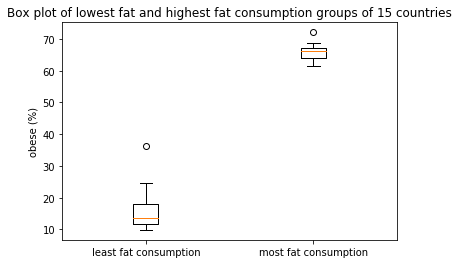

In [27]:
lowest_fat_consumption_by_country = food_consumption_and_obesity_data_by_country.nsmallest(15, "fat")
highest_fat_consumption_by_country = food_consumption_and_obesity_data_by_country.nlargest(15, "fat")
plt.title("Box plot of lowest fat and highest fat consumption groups of 15 countries")
plt.boxplot([lowest_fat_consumption_by_country["obese percentage"], highest_fat_consumption_by_country["obese percentage"]], labels = ["least fat consumption", "most fat consumption"])
plt.ylabel("obese (%)")
plt.show()

The boxplot shows that compared groups differ significantly even the outlier in least fat group.

Testing hypotisis that fat consumption leads to obesity.
To perform a hypothesis test, we'll need a hypothesis. Actually, a pair of hypotheses. The "null hypothesis", $H_0$ says that "there's nothing interesting going on with the data". The "alternative hypothesis", $H_1$ says the opposite.

We want to prove whether or not fat consumption is correlated with obesity. Therefore:
* $H_0:$ fat consumption is not correlated with obesity. `lowest_fat_consumption_by_country["obese percentage"]` and `highest_fat_consumption_by_country["obese percentage"]` are two samples from the same distribution.
* $H_1:$ `lowest_fat_consumption_by_country["obese percentage"]` and `highest_fat_consumption_by_country["obese percentage"]` come from two different distributions.

Ideally, **we'd like to reject the null hypothesis**.

Here's a quick explanation of the process: we'll perform a test. The exact details aren't important. We assume that $H_0$ is true, therefore **the differences between the two boxplots occur simply by chance**. The test will return a $p$-value. It corresponds to the probability that we observe **as extreme or more extreme differences** between the two histograms if $H_0$ is really true.

**If $p\le1\%$, we will reject $H_0$**.

In [28]:
test_result = f_oneway(lowest_fat_consumption_by_country["obese percentage"], highest_fat_consumption_by_country["obese percentage"])
print(test_result)
if test_result.pvalue <= 0.01:
    print("The differences in obesity percentage are significant. Reject H0.")
else:
    print("There's not enough evidence to reject H0. Don't accept or reject anything else.")

F_onewayResult(statistic=680.7151663565699, pvalue=3.437574093213969e-21)
The differences in obesity percentage are significant. Reject H0.


The test output yields an F-statistic of 680.715 and a p-value of almost 0, indicating that there is significant difference between the means of each group.
The test result suggests the groups don't have the same sample means in this case, since the p-value is significant at a 99% confidence level. 

#### Causes of death by country 

Causes of death vary significantly by country and income levels across the world. These deaths are shown as a percentage of total deaths.
We will find and research the causes with the largest percentage. 

In [29]:
deaths_by_cause = pd.read_csv("data/share-of-deaths-by-cause-2016.csv")
deaths_by_cause_by_country = group_data_by_country(deaths_by_cause)
deaths_by_cause_by_country.head()

deaths_by_cause_by_country.mean().nlargest(3)

Cardiovascular diseases (%)    30.328648
Cancers (%)                    15.971221
Diabetes (%)                    7.440510
dtype: float64

#### Cardiovascular diseases
Lets do the same as we did with obesity. First we will group by country again and concatenate with food_consumption_data_by_country.

In [30]:
deaths_by_highest_cause_by_country = deaths_by_cause_by_country.loc[:,["Cardiovascular diseases (%)", "Cancers (%)", "Diabetes (%)"]]
food_consumption_and_deaths_data_by_country = pd.concat([food_consumption_data_by_country, deaths_by_highest_cause_by_country], axis=1, join='outer')
food_consumption_and_deaths_data_by_country = food_consumption_and_deaths_data_by_country.dropna(how="any", axis=0)
corr = food_consumption_and_deaths_data_by_country.corr()
corr.style.background_gradient()

,animal protein,plant protein,fat,carbohydrates,other,sugar,oils & fat,meat,dairy & eggs,fruits & vegetables,starchy,pulses,cereals & grains,alcoholic,Cardiovascular diseases (%),Cancers (%),Diabetes (%)
animal protein,1,-0.267062,0.857775,-0.0343982,0.588653,0.608828,0.551195,0.91341,0.809201,0.305805,-0.32736,-0.466555,-0.387094,0.601374,0.515752,0.797157,0.0806498
plant protein,-0.267062,1,-0.184396,0.677574,-0.16408,-0.243531,-0.140635,-0.344221,-0.0830586,0.131149,-0.0453637,0.350949,0.732462,-0.194963,0.0240592,-0.2037,-0.160663
fat,0.857775,-0.184396,1,-0.0636506,0.452232,0.582427,0.851327,0.77514,0.755964,0.300973,-0.304015,-0.41812,-0.377427,0.571575,0.470441,0.773776,0.0305051
carbohydrates,-0.0343982,0.677574,-0.0636506,1,0.026432,0.158402,-0.0617896,-0.112589,0.0264659,0.284105,0.0978928,0.0757409,0.56058,0.0315366,0.198387,0.0083671,0.0286781
other,0.588653,-0.16408,0.452232,0.026432,1,0.314329,0.157277,0.557199,0.482102,0.277517,-0.190786,-0.325416,-0.230508,0.37297,0.393254,0.504129,0.161817
sugar,0.608828,-0.243531,0.582427,0.158402,0.314329,1,0.439738,0.523625,0.530069,0.152663,-0.434784,-0.226307,-0.254543,0.356307,0.358273,0.610633,0.35012
oils & fat,0.551195,-0.140635,0.851327,-0.0617896,0.157277,0.439738,1,0.449459,0.418631,0.208842,-0.143059,-0.283725,-0.32975,0.367461,0.244881,0.540503,0.0813931
meat,0.91341,-0.344221,0.77514,-0.112589,0.557199,0.523625,0.449459,1,0.603047,0.272829,-0.273714,-0.473381,-0.407737,0.5346,0.427932,0.743847,0.14473
dairy & eggs,0.809201,-0.0830586,0.755964,0.0264659,0.482102,0.530069,0.418631,0.603047,1,0.275519,-0.37532,-0.342826,-0.24708,0.548713,0.60602,0.672154,-0.117681
fruits & vegetables,0.305805,0.131149,0.300973,0.284105,0.277517,0.152663,0.208842,0.272829,0.275519,1,0.0623283,-0.0124887,-0.237449,0.101812,0.297971,0.311974,0.0456295


We see for "Cardiovascular diseases" and "Cancers" strong correlation with animal products consumption.

Now we again compare the distributions with boxplot of lowest fat and highest fat consumption groups of 15 countries.

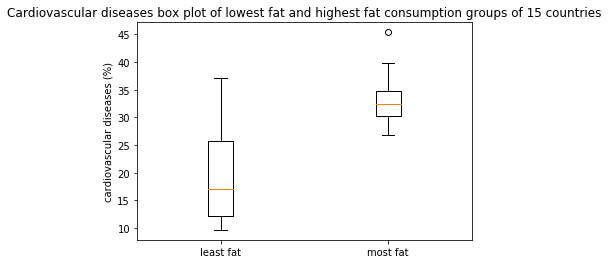

In [31]:
lowest_fat_consumption_by_country = food_consumption_and_deaths_data_by_country.nsmallest(15, "fat")
highest_fat_consumption_by_country = food_consumption_and_deaths_data_by_country.nlargest(15, "fat")

plt.title("Cardiovascular diseases box plot of lowest fat and highest fat consumption groups of 15 countries")
plt.boxplot([lowest_fat_consumption_by_country["Cardiovascular diseases (%)"], highest_fat_consumption_by_country["Cardiovascular diseases (%)"]], labels = ["least fat", "most fat"])
plt.ylabel("cardiovascular diseases (%)")
plt.show()


Lets form and test hypothesis again.
We want to prove whether or not fat consumption is correlated with cardiovascular diseases. Therefore:
* $H_0:$ fat consumption is not correlated with cardiovascular diseases. `lowest_fat_consumption_by_country["Cardiovascular diseases (%)"]` and `highest_fat_consumption_by_country["Cardiovascular diseases (%)"]` are two samples from the same distribution.
* $H_1:$ `lowest_fat_consumption_by_country["Cardiovascular diseases (%)"]` and `highest_fat_consumption_by_country["Cardiovascular diseases (%)"]` come from two different distributions.

In [32]:
test_result = f_oneway(lowest_fat_consumption_by_country["Cardiovascular diseases (%)"], highest_fat_consumption_by_country["Cardiovascular diseases (%)"])
print(test_result)
if test_result.pvalue <= 0.01:
    print("The differences in cardiovascular diseases percentage are significant. Reject H0.")
else:
    print("There's not enough evidence to reject H0. Don't accept or reject anything else.")

F_onewayResult(statistic=29.36057231821909, pvalue=8.843505255040975e-06)
The differences in cardiovascular diseases percentage are significant. Reject H0.


The test result shows the groups don't have the same sample means in this case, since the p-value is significant at a 99% confidence level. 

#### Cancers

Comparing the distributions with boxplot of lowest fat and highest fat consumption groups of 15 countries.

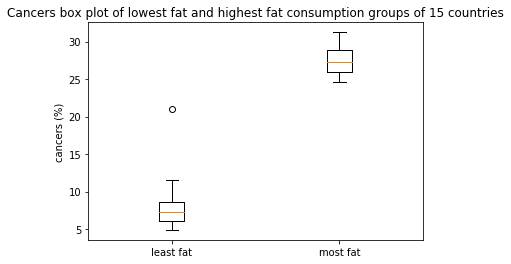

In [33]:
lowest_fat_consumption_by_country = food_consumption_and_deaths_data_by_country.nsmallest(15, "fat")
highest_fat_consumption_by_country = food_consumption_and_deaths_data_by_country.nlargest(15, "fat")
plt.title("Cancers box plot of lowest fat and highest fat consumption groups of 15 countries")
plt.boxplot([lowest_fat_consumption_by_country["Cancers (%)"], highest_fat_consumption_by_country["Cancers (%)"]], labels = ["least fat", "most fat"])
plt.ylabel("cancers (%)")
plt.show()

Lets form and test hypothesis again.
We want to prove whether or not fat consumption is correlated with cancers. Therefore:
* $H_0:$ fat consumption is not correlated with cancers. `lowest_fat_consumption_by_country["Cancers (%)"]` and `highest_fat_consumption_by_country["Cancers (%)"]` are two samples from the same distribution.
* $H_1:$ `lowest_fat_consumption_by_country["Cancers (%)"]` and `highest_fat_consumption_by_country["Cancers (%)"]` come from two different distributions.

In [34]:
test_result = f_oneway(lowest_fat_consumption_by_country["Cancers (%)"], highest_fat_consumption_by_country["Cancers (%)"])
print(test_result)
if test_result.pvalue <= 0.01:
    print("The differences in cancers percentage are significant. Reject H0.")
else:
    print("There's not enough evidence to reject H0. Don't accept or reject anything else.")

F_onewayResult(statistic=274.7115708430773, pvalue=5.246894343859478e-16)
The differences in cancers percentage are significant. Reject H0.


#### Diabetes
Comparing the distributions with boxplot of lowest sugar and highest sugar consumption groups of 15 countries.

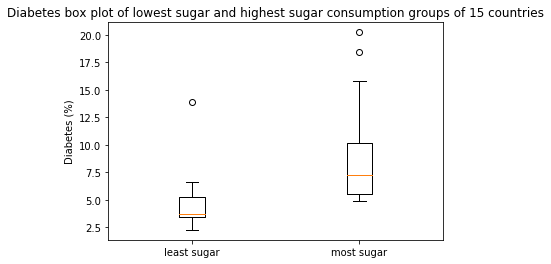

In [35]:
lowest_sugar_consumption_by_country = food_consumption_and_deaths_data_by_country.nsmallest(15, "sugar")
highest_sugar_consumption_by_country = food_consumption_and_deaths_data_by_country.nlargest(15, "sugar")
plt.title("Diabetes box plot of lowest sugar and highest sugar consumption groups of 15 countries")
plt.boxplot([lowest_sugar_consumption_by_country["Diabetes (%)"], highest_sugar_consumption_by_country["Diabetes (%)"]], labels = ["least sugar", "most sugar"])
plt.ylabel("Diabetes (%)")
plt.show()

We want to prove whether or not sugar consumption is correlated with diabetes. Therefore:
* $H_0:$ sugar consumption is not correlated with diabetes. `lowest_sugar_consumption_by_country["Diabetes (%)"]` and `highest_sugar_consumption_by_country["Diabetes (%)"]` are two samples from the same distribution.
* $H_1:$ `lowest_sugar_consumption_by_country["Diabetes (%)"]` and `highest_sugar_consumption_by_country["Diabetes (%)"]` come from two different distributions.

In [36]:
test_result = f_oneway(lowest_sugar_consumption_by_country["Diabetes (%)"], highest_sugar_consumption_by_country["Diabetes (%)"])
print(test_result)
if test_result.pvalue <= 0.01:
    print("The differences in diabetes percentage are significant. Reject H0.")
else:
    print("There's not enough evidence to reject H0. Don't accept or reject anything else.")

F_onewayResult(statistic=8.512774904986745, pvalue=0.006879272969856234)
The differences in diabetes percentage are significant. Reject H0.


#### Morbidity by country 

We saw that top 3 causes of death are related with food types that people eat worldwide.

Now we will try to find a model which we can predict years of living with disability or disease burden

In [37]:
years_with_disability_or_disease = pd.read_csv("data/expected-years-of-living-with-disability-or-disease-burden.csv")
years_with_disability_or_disease_by_country = group_data_by_country(years_with_disability_or_disease)
years_with_disability_or_disease_by_country. columns = ["years with disability / disease"]
years_with_disability_or_disease_by_country.head()

,years with disability / disease
Entity,
Afghanistan,8.446667
Albania,9.798333
Algeria,11.326667
American Samoa,9.708333
Andorra,11.353333


In [38]:
food_consumption_and_health_data_by_country = pd.concat([commodity_groups_compositions_by_country, years_with_disability_or_disease_by_country], axis=1, join='outer')
food_consumption_and_health_data_by_country = food_consumption_and_health_data_by_country.dropna(how="any", axis=0)
corr = food_consumption_and_health_data_by_country.corr()
corr.style.background_gradient()

,other,sugar,oils & fat,meat,dairy & eggs,fruits & vegetables,starchy,pulses,cereals & grains,alcoholic,years with disability / disease
other,1,0.314329,0.157277,0.557199,0.482102,0.277517,-0.190786,-0.325416,-0.230508,0.37297,0.444381
sugar,0.314329,1,0.439738,0.523625,0.530069,0.152663,-0.434784,-0.226307,-0.254543,0.356307,0.59304
oils & fat,0.157277,0.439738,1,0.449459,0.418631,0.208842,-0.143059,-0.283725,-0.32975,0.367461,0.538368
meat,0.557199,0.523625,0.449459,1,0.603047,0.272829,-0.273714,-0.473381,-0.407737,0.5346,0.52214
dairy & eggs,0.482102,0.530069,0.418631,0.603047,1,0.275519,-0.37532,-0.342826,-0.24708,0.548713,0.639707
fruits & vegetables,0.277517,0.152663,0.208842,0.272829,0.275519,1,0.0623283,-0.0124887,-0.237449,0.101812,0.384869
starchy,-0.190786,-0.434784,-0.143059,-0.273714,-0.37532,0.0623283,1,0.187011,-0.337234,-0.105665,-0.421238
pulses,-0.325416,-0.226307,-0.283725,-0.473381,-0.342826,-0.0124887,0.187011,1,0.0495,-0.327858,-0.284003
cereals & grains,-0.230508,-0.254543,-0.32975,-0.407737,-0.24708,-0.237449,-0.337234,0.0495,1,-0.351754,-0.0784138
alcoholic,0.37297,0.356307,0.367461,0.5346,0.548713,0.101812,-0.105665,-0.327858,-0.351754,1,0.386292


### Predicting number of years with disability or desease based on food commodity groups compositions

In order to predict the number of years with disability or desease based on food commodity groups compositions we will use Linear regression.

Linear regression is a statistical model that examines the linear relationship between two (Simple Linear Regression ) or more (Multiple Linear Regression) variables — a dependent variable and independent variable(s). Linear relationship basically means that when one (or more) independent variables increases (or decreases), the dependent variable increases (or decreases) too.
 
In this equation, Y - *years with disability or desease* is the *dependent* variable — or the variable we are trying to predict or estimate; X - *food compositions by commodity groups* is *independent* variables — the variables we are using to make predictions; m is the slope of the regression line — it represent the effect X has on Y. In other words, if X increases by 1 unit, Y will increase by exactly m units. (“Full disclosure”: this is true only if we know that X and Y have a linear relationship. In almost all linear regression cases, this will not be true!) b is a constant, also known as the Y-intercept. If X equals 0, Y would be equal to b (Caveat: see full disclosure from earlier!). This is not necessarily applicable in real life — we won’t always know the exact relationship between X and Y or have an exact linear relationship.

Linear regression produces a model in the form:
 
 $ Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 … + \beta_n X_n $
 
 Scikit-learn provides a LinearRegression.
 We perform basic preparation of the data for modelling and create the model. 

In [39]:
food_consumption_and_health_data_by_country_features = food_consumption_and_health_data_by_country.drop("years with disability / disease", axis = 1)
food_consumption_and_health_data_by_country_target = food_consumption_and_health_data_by_country["years with disability / disease"]
scaler = MinMaxScaler()
food_consumption_and_health_data_by_country_features_scaled = scaler.fit_transform(food_consumption_and_health_data_by_country_features)
#print(data_by_country_features)
features_train, features_test, target_train, target_test = train_test_split(
    food_consumption_and_health_data_by_country_features_scaled, food_consumption_and_health_data_by_country_target, train_size = 0.7, test_size = 0.3, random_state = 42)
#print(features_train.shape, features_test.shape, target_train.shape, target_test.shape, sep = "\r\n")

model = LinearRegression()
model.fit(features_train, target_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

##### Scoring the model

A common method of measuring the accuracy of regression models is to use the R2 statistic.

The $R^2$ statistic is defined as follows:

$R^2 = 1 – \dfrac{RSS}{TSS}$

The RSS (Residual sum of squares) measures the variability left unexplained after performing the regression
The TSS measues the total variance in Y
Therefore the $R^2$ statistic measures proportion of variability in Y that is explained by X using our model
$R^2$ can be determined using our test set and the model’s score method.

In [40]:
score = model.score(features_test, target_test)
print("LinearRegression score: {}".format(score))

target_pred = model.predict(features_test)  
print('Mean Absolute Error:', metrics.mean_absolute_error(target_test, target_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(target_test, target_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(target_test, target_pred)))  

LinearRegression score: 0.5883368201589645
Mean Absolute Error: 0.6633922010694491
Mean Squared Error: 0.6532016879558022
Root Mean Squared Error: 0.8082089383048187


Now lets try to clasify values for years with disability / disease with low or high. We will determine that by comparing the values to the rounded mean value.

We will try to predict if the number of years with disability or desease will be high or low based on food commodity groups compositions we will use Logistic regression.

Logistic Regression is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. In logistic regression, the dependent variable is a binary variable that contains data coded as 1 (yes, success, etc.) or 0 (no, failure, etc.). In other words, the logistic regression model predicts P(Y=1) as a function of X.

In [41]:
years_with_disability_mean = round(food_consumption_and_health_data_by_country["years with disability / disease"].mean())
food_consumption_and_health_data_by_country["many years with disability"] = food_consumption_and_health_data_by_country.apply(lambda row: int(row['years with disability / disease'] > years_with_disability_mean) , axis=1) 

In [42]:
food_consumption_and_health_data_by_country_features = food_consumption_and_health_data_by_country.drop(["years with disability / disease", "many years with disability"], axis = 1)
food_consumption_and_health_data_by_country_target = food_consumption_and_health_data_by_country["many years with disability"]
scaler = MinMaxScaler()
food_consumption_and_health_data_by_country_features_scaled = scaler.fit_transform(food_consumption_and_health_data_by_country_features)
#print(data_by_country_features)
features_train, features_test, target_train, target_test = train_test_split(
    food_consumption_and_health_data_by_country_features_scaled, food_consumption_and_health_data_by_country_target, train_size = 0.7, test_size = 0.3, random_state = 42)
#print(features_train.shape, features_test.shape, target_train.shape, target_test.shape, sep = "\r\n")

model = LogisticRegression()
model.fit(features_train, target_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [43]:
score = model.score(features_test, target_test)
print("LogisticRegression score: {}".format(score))

LogisticRegression score: 0.8


### Conclusion

We have researched the most consumed food types worldwide and found out that there is a tendancy of obesity last decades. This tendancy correlates closely with the cosumption of animal products rich in fats and also sugars. These product categories we found in the world foods dataset and determined the following: 
high-fats foods: cheese, meat, dairy, spreads 
high-sugars foods: sugary snacks, syrups, sweet spreads, sugared beverage. 

Data analysis of the food cosumption by country has shown us strong correlation with the top 3 causes of death worldwide. This led to the assumption that people's food choices impact on the number of years with disease or disabily during thir lifes. We used linaer and logistic regression to predict them and found out that variability in these number of years is explained by food consumption by groups in high percentage.

#### Refferences

https://ourworldindata.org/

https://towardsdatascience.com

http://stackabuse.com/linear-regression-in-python-with-scikit-learn/

https://www.nationalgeographic.com/what-the-world-eats/